# Initial data setup

## Imports

In [ ]:
import pandas as pd

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Data loading

### Address

In [ ]:
all_addresses = pd.read_csv("../data/1_raw/bm_address.csv")
all_addresses.rename(columns={'id': 'address_id'}, inplace=True)


/var/folders/zv/r1h2xchs1gb4qpx11mwzrrv40000gn/T/ipykernel_63229/537795448.py:1: DtypeWarning: Columns (10,13,51) have mixed types. Specify dtype option on import or set low_memory=False.
  all_addresses = pd.read_csv("../data/1_raw/bm_address.csv")


In [ ]:
# Sample 100 rows evenly spread throughout the addresses dataframe

sample_indices = np.linspace(0, len(all_addresses) - 1, 100, dtype=int)
address_samples = all_addresses.iloc[sample_indices]

# Write to CSV
address_samples.to_csv("../data/2_interim/100_address_samples_evenly_spread.csv", index=False)


### Ads

In [ ]:
all_ads = pd.read_csv("../data/1_raw/finn_ads.csv")

In [ ]:
# Sample 100 rows evenly spread throughout the ads dataframe
sample_indices = np.linspace(0, len(all_ads) - 1, 1000, dtype=int)
ads_sample = all_ads.iloc[sample_indices]

# Write to CSV
ads_sample.to_csv("../data/2_interim/1000_ads_evenly_spread.csv", index=False)

### Transactions

In [ ]:
all_transactions = pd.read_csv("../data/1_raw/bm_market_transactions.csv")
all_transactions.rename(columns={'id': 'transaction_id'}, inplace=True)

### Enova

In [ ]:
enova = pd.read_csv("../data/1_raw/bm_enova_unit.csv")

# Pre-filtering

## Filtering transactions
Discarding transactions above 30M NOK, and transactions without a date

In [ ]:
print("Number of transactions before 30M-filtering:", len(all_transactions))
processed_transactions = all_transactions[all_transactions['official_price'] <= 30000000]
print("Number of transactions after 30M-filtering:", len(processed_transactions))
processed_transactions = processed_transactions.dropna(subset=['sold_date', 'official_date'], how='all')
print("Number of transactions after empty-date-filtering:", len(processed_transactions))

Number of transactions before 30M-filtering: 3339568


Number of transactions after 30M-filtering: 3167461
Number of transactions after empty-date-filtering: 3167461


## Filtering homes
Discarding homes with more than 20 rooms or more than 5 bathrooms, along with properties older than 125 years (established before 1900).

In [ ]:
print("Number of addresses before room-filtering:", len(all_addresses))
filtered_addresses = all_addresses[(all_addresses['antallrom'] < 21) & (all_addresses['antallbad'] < 6)]
print("Number of addresses after room-filtering:", len(filtered_addresses))

# Remove rows where etablertdato is earlier than 1900
filtered_addresses['etablertdato'] = pd.to_datetime(filtered_addresses['etablertdato'], errors='coerce')
filtered_addresses = filtered_addresses[
	(filtered_addresses['etablertdato'].isna()) | (filtered_addresses['etablertdato'].dt.year >= 1900)
]
print("Number of addresses after etablertdato-filtering:", len(filtered_addresses))

Number of addresses before room-filtering: 3143460
Number of addresses after room-filtering: 3141881


/var/folders/zv/r1h2xchs1gb4qpx11mwzrrv40000gn/T/ipykernel_63229/1529089899.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_addresses['etablertdato'] = pd.to_datetime(filtered_addresses['etablertdato'], errors='coerce')


Number of addresses after etablertdato-filtering: 3029702


## Filtering buildings

In [ ]:
relevant_buildings = all_addresses[all_addresses["bygningstype"].isin(["Enebolig", "Rekkehus", "Tomannsbolig, vertikaldelt", "Enebolig m/hybel/sokkelleil.", "Tomannsbolig, horisontaldelt"])]

In [ ]:
print(f"Number of relevant buildings nationwide: {len(relevant_buildings)}")

Number of relevant buildings nationwide: 1438693


## Filtering kommune

Liste over kommunenr:
* Oslo: 301 (offisielt "0301" men "301" i datasettet)
* Lørenskog: 3222 (tidligare 3029)
* Lillestrøm: 3205 (tidligare 3030)
* Bærum: 3201 (tidligare 3024)
* Asker: 3203 (tidligare 3025)
* Drammen: 3301 (tidligare 3005)

"Tidligere" referer til hva kommunenummeret var før 2023. Ingen andre kommuner har nye kommunenummer som er likt dessa gamle kommunenummera. Per har testa kjapt at det ikkje er noen addresser registrert på gamle kommunenr

In [ ]:
kommunenr_east = [301, 3201, 3301, 3203, 3205, 3222]

In [ ]:
eastern_addresses = all_addresses[all_addresses["kommunenr"].isin(kommunenr_east)]


In [ ]:
eastern_relevant_addresses = eastern_addresses[eastern_addresses["bygningstype"].isin(relevant_buildings["bygningstype"].unique())]
eastern_relevant_addresses.to_csv("../data/2_interim/eastern_relevant_addresses.csv", index=False)

In [ ]:
print(f"Number of relevant buildings nationwide: {len(relevant_buildings)}")
print(f"Number of relevant buildings in Eastern Norway: {len(eastern_relevant_addresses)}")

Number of relevant buildings nationwide: 1438693
Number of relevant buildings in Eastern Norway: 167040


## Counting remaining building types

In [ ]:
# Count occurrences of each bygningstype in eastern municipalities
buildings_count_east = eastern_addresses["bygningstype"].value_counts()

# Filter to only those with more than 1000 occurrences
buildings_count_east_filtered = buildings_count_east[buildings_count_east > 1000]

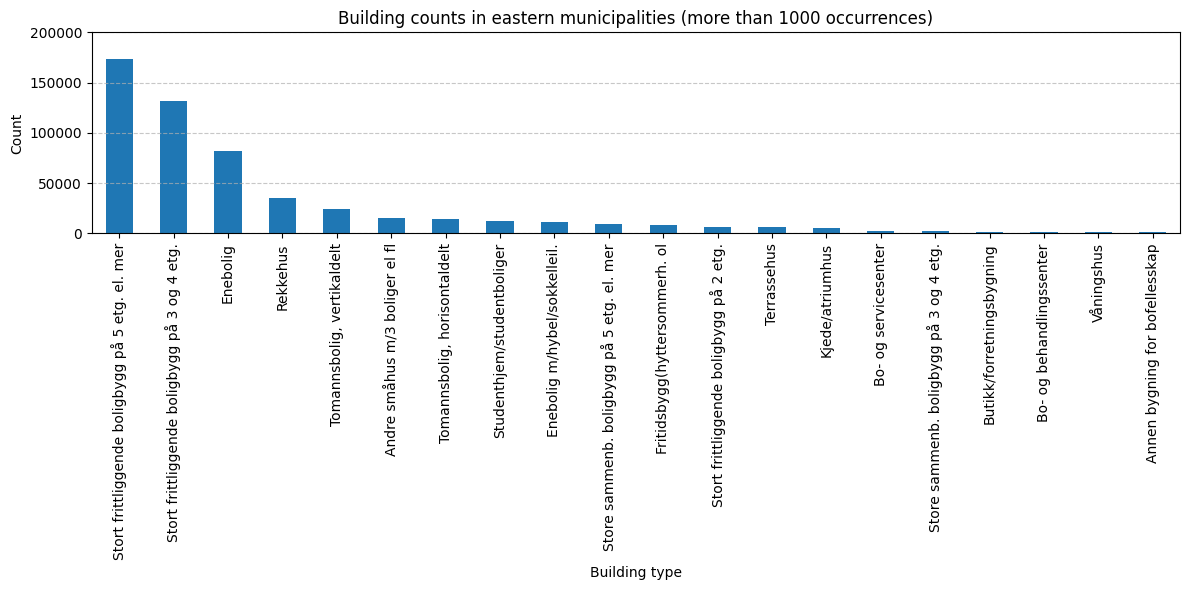

In [ ]:

# Plot the result
plt.figure(figsize=(12, 6))
buildings_count_east_filtered.plot(kind='bar')

plt.title("Building counts in eastern municipalities (more than 1000 occurrences)")
plt.xlabel("Building type")
plt.ylabel("Count")

plt.ylim(0, 200000)  # expand y-axis
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

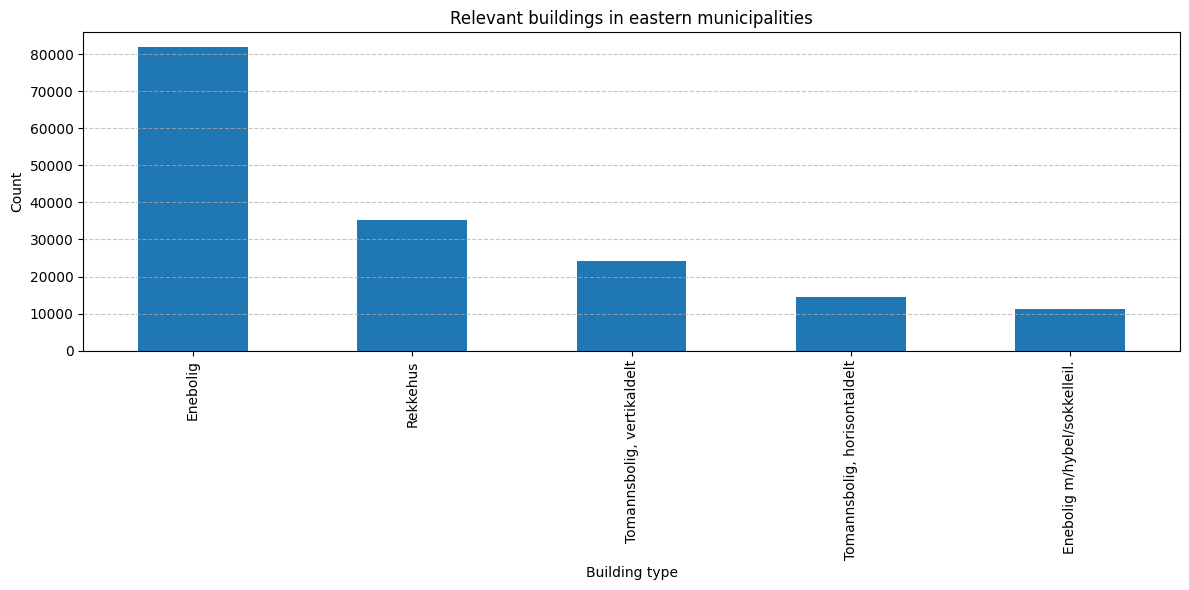

In [ ]:
# Count occurrences of each bygningstype in eastern municipalities
relevant_buildings_count_east = eastern_relevant_addresses["bygningstype"].value_counts()

# Plot the result
plt.figure(figsize=(12, 6))
relevant_buildings_count_east.plot(kind='bar')
plt.title("Relevant buildings in eastern municipalities")
plt.xlabel("Building type")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Filtering for multiple-ads

### Addresses with multiple transactions

In [ ]:
# Find address_id with more than one transaction_id
address_transaction_counts = processed_transactions.groupby('address_id')['transaction_id'].nunique()
addresses_with_multiple_transactions = address_transaction_counts[address_transaction_counts > 1].index
addresses_with_one_transaction = address_transaction_counts[address_transaction_counts == 1].index
addresses_without_relevant_transactions = all_addresses[~all_addresses['address_id'].isin(processed_transactions['address_id'])]['address_id']
addresses_without_transactions = all_addresses[~all_addresses['address_id'].isin(all_transactions['address_id'])]['address_id']

print(f"Number of addresses with multiple transactions: {len(addresses_with_multiple_transactions)}")

Number of addresses with multiple transactions: 818591


In [ ]:
# Get the address_id column from addresses_east as a set
eastern_relevant_addresses_ids = set(eastern_relevant_addresses["address_id"])

# Intersection with addresses_with_multiple_transactions (which is an Index, so convert to set)
eastern_addresses_with_multiple_transactions = set(addresses_with_multiple_transactions) & eastern_relevant_addresses_ids
eastern_addresses_with_one_transaction = set(addresses_with_one_transaction) & eastern_relevant_addresses_ids
eastern_addresses_without_relevant_transactions = set(addresses_without_relevant_transactions) & eastern_relevant_addresses_ids
eastern_addresses_without_transactions = set(addresses_without_transactions) & eastern_relevant_addresses_ids
eastern_addresses_with_transactions = (eastern_addresses_with_multiple_transactions | eastern_addresses_with_one_transaction)

# Filter processed_transactions for these addresses
multiple_transactions_df = processed_transactions[processed_transactions['address_id'].isin(eastern_addresses_with_multiple_transactions)]

print(f"Number of relevant eastern addresses: {len(eastern_relevant_addresses)}")
print(f"Number of relevant eastern addresses with multiple transactions recorded: {len(eastern_addresses_with_multiple_transactions)}")
print(f"Number of relevant eastern addresses with one transaction recorded: {len(eastern_addresses_with_one_transaction)}")
print(f"Number of relevant eastern addresses without relevant transactions recorded: {len(eastern_addresses_without_transactions)}")
print(f"Number of relevant eastern addresses without any transactions recorded: {len(eastern_addresses_without_transactions)}")
print(f"Number of transactions for relevant eastern addresses: {len(multiple_transactions_df)}")


Number of relevant eastern addresses: 167040
Number of relevant eastern addresses with multiple transactions recorded: 53039
Number of relevant eastern addresses with one transaction recorded: 60303
Number of relevant eastern addresses without relevant transactions recorded: 50152
Number of relevant eastern addresses without any transactions recorded: 50152
Number of transactions for relevant eastern addresses: 141411


Omtrent 1/3 av relevante addresser for oppgava har ikkje transaksjoner!

### Addresses with multiple ads

In [ ]:
# Find address_id with more than one ad_code
processed_transactions_with_ads  = processed_transactions[processed_transactions['ad_code'].notna() & (processed_transactions['ad_code'] != '')]
address_ad_counts = processed_transactions_with_ads.groupby('address_id')['ad_code'].nunique()
addresses_with_multiple_ads = address_ad_counts[address_ad_counts > 1].index

print(f"Number of addresses nationwide with multiple ads: {len(addresses_with_multiple_ads)}")


# Filter processed_transactions where ad_code is not in any ad_code in all_ads
processed_transactions_without_ads = processed_transactions[
	~processed_transactions['ad_code'].isin(all_ads['ad_code'])
]


Number of addresses nationwide with multiple ads: 171625


In [ ]:
# Get a set of address_id from processed_transactions_without_ads
address_ids_with_transactions_without_ads = set(processed_transactions_without_ads['address_id'])
print(f"Number of unique address_id without ads: {len(address_ids_with_transactions_without_ads)}")

Number of unique address_id without ads: 1467692


In [ ]:
# Intersection with addresses_with_multiple_ads (which is an Index, so convert to set)
eastern_addresses_with_multiple_ads = set(addresses_with_multiple_ads) & eastern_relevant_addresses_ids
eastern_addresses_with_transactions_without_ads = set(processed_transactions_without_ads) & eastern_relevant_addresses_ids

# Filter processed_transactions_with_ads for these addresses
transactions_with_multiple_ads = processed_transactions_with_ads[processed_transactions_with_ads['address_id'].isin(eastern_addresses_with_multiple_ads)]
print(f"Number of relevant eastern addresses with multiple ads: {len(eastern_addresses_with_multiple_ads)}")
print(f"Number of ads for these addresses: {len(transactions_with_multiple_ads)}")

Number of relevant eastern addresses with multiple ads: 8303
Number of ads for these addresses: 18085


In [ ]:
# Get all distinct address_id in transactions_with_multiple_ads
final_address_ids = eastern_addresses_with_multiple_ads

In [ ]:
final_addresses = eastern_relevant_addresses[eastern_relevant_addresses['address_id'].isin(final_address_ids)]

# Stats for final dataframes

In [ ]:
print(f"Number of relevant eastern addresses with multiple ads: {len(eastern_addresses_with_multiple_ads)}")
print(f"Number of ads for these addresses: {len(transactions_with_multiple_ads)}")

Number of relevant eastern addresses with multiple ads: 8303
Number of ads for these addresses: 18085


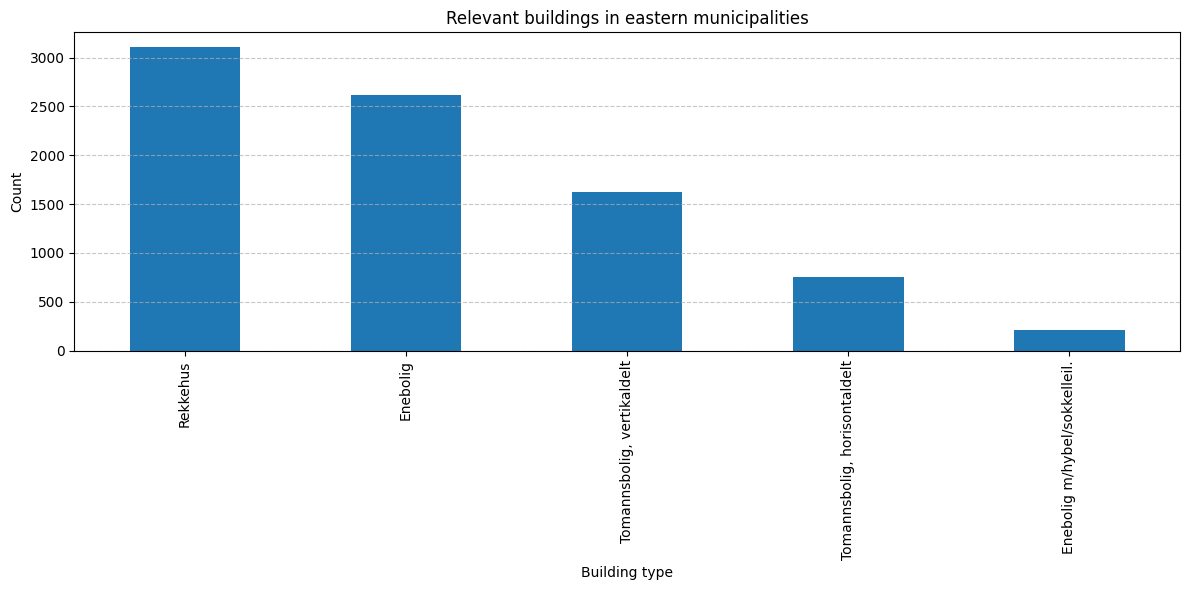

In [ ]:
# Count occurrences of each bygningstype in eastern municipalities
relevant_buildings_count_final = final_addresses["bygningstype"].value_counts()

# Plot the result
plt.figure(figsize=(12, 6))
relevant_buildings_count_final.plot(kind='bar')
plt.title("Relevant buildings in eastern municipalities")
plt.xlabel("Building type")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
relevant_ads = all_ads[all_ads['ad_code'].isin(transactions_with_multiple_ads['ad_code'])]
print(f"Number of relevant ads for these addresses: {len(relevant_ads)}")

Number of relevant ads for these addresses: 18085


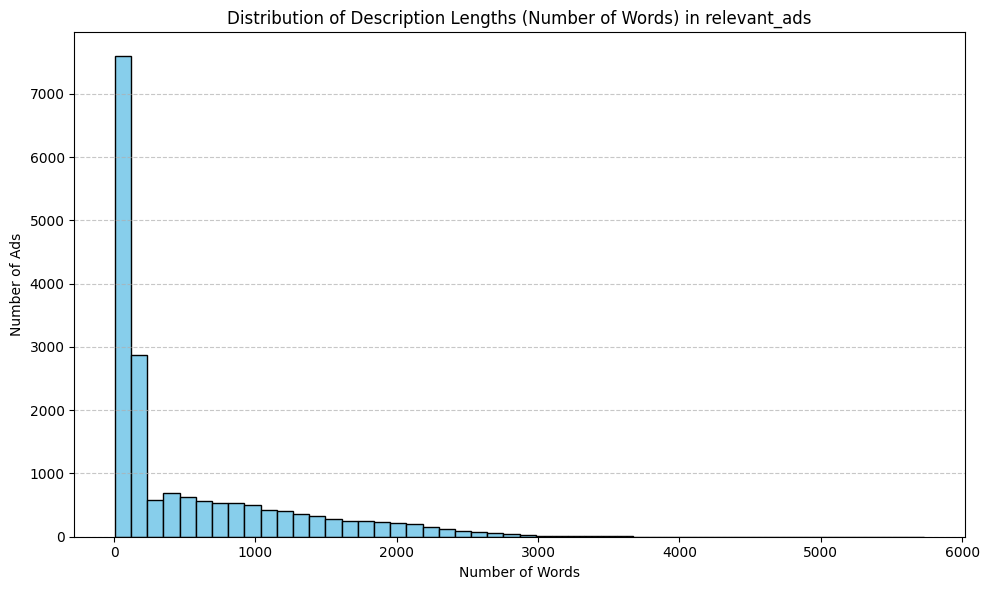

In [ ]:
# Calculate the number of words in each description
desc_word_counts = relevant_ads['description'].dropna().apply(lambda x: len(str(x).split()))

# Plot a histogram of the word counts
plt.figure(figsize=(10, 6))
plt.hist(desc_word_counts, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Description Lengths (Number of Words) in relevant_ads')
plt.xlabel('Number of Words')
plt.ylabel('Number of Ads')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


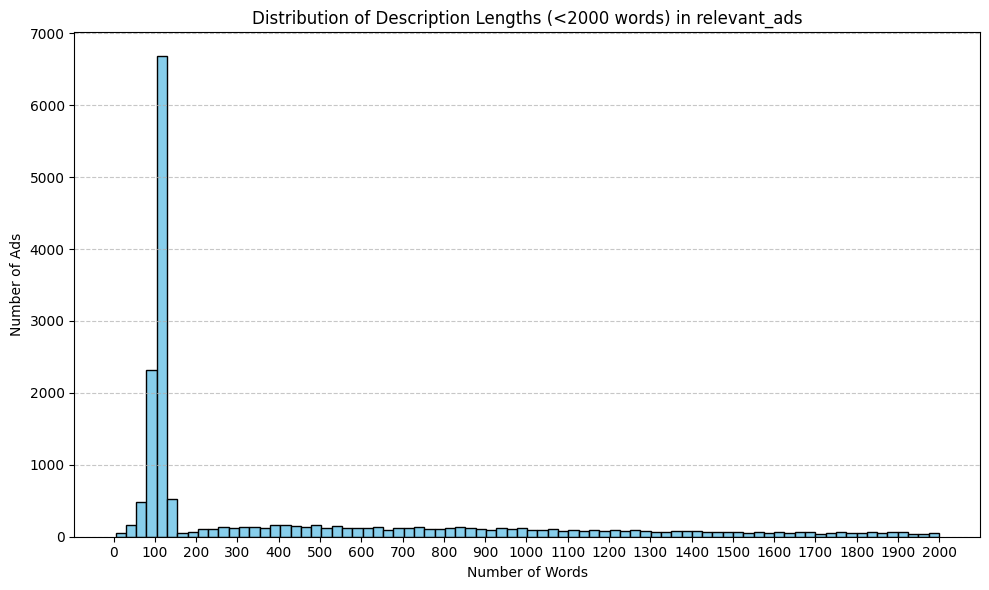

In [ ]:
# Calculate word counts
desc_word_counts = relevant_ads['description'].dropna().apply(lambda x: len(str(x).split()))

# Filter to only ads with < 2000 words
filtered_counts = desc_word_counts[desc_word_counts < 2000]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_counts, bins=80, color='skyblue', edgecolor='black')

plt.title('Distribution of Description Lengths (<2000 words) in relevant_ads')
plt.xlabel('Number of Words')
plt.ylabel('Number of Ads')

# Set x-axis ticks every 100 words
plt.xticks(np.arange(0, 2001, 100))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
transactions_without_ads = processed_transactions[processed_transactions['address_id'].isin(eastern_addresses_without_transactions)]
print(f"Number of transactions without ads: {len(transactions_without_ads)}")

Number of transactions without ads: 0


In [ ]:
# Parse dates; invalid/missing -> NaT
dates = pd.to_datetime(transactions_without_ads['official_date'], errors='coerce')

# Keep only valid dates
valid_years = dates.dropna().dt.year.astype(int)

# If nothing valid, bail out early
if valid_years.empty:
    print("No valid dates found in 'official_date'.")
else:
    # Count transactions per year
    year_counts = valid_years.value_counts().sort_index()

    # Plot
    plt.figure(figsize=(10, 6))
    year_counts.plot(kind="bar", color="skyblue", edgecolor="black")

    plt.title("Number of Transactions per Year (transactions_without_ads)")
    plt.xlabel("Year")
    plt.ylabel("Number of Transactions")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

No valid dates found in 'official_date'.


In [ ]:
# Parse dates; invalid/missing -> NaT
dates = pd.to_datetime(transactions_without_ads['sold_date'], errors='coerce')

# Keep only valid dates
valid_years = dates.dropna().dt.year.astype(int)

# If nothing valid, bail out early
if valid_years.empty:
    print("No valid dates found in 'sold_date'.")
else:
    # Count transactions per year
    year_counts = valid_years.value_counts().sort_index()

    # Plot
    plt.figure(figsize=(10, 6))
    year_counts.plot(kind="bar", color="skyblue", edgecolor="black")

    plt.title("Number of Transactions per Year (transactions_without_ads)")
    plt.xlabel("Year")
    plt.ylabel("Number of Transactions")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

No valid dates found in 'sold_date'.


# Samling 150 ads from relevant ads

In [ ]:
# Assume relevant_ads is your DataFrame
n_rows = 150
total_rows = len(relevant_ads)

# Pick evenly spaced indices
indices = np.linspace(0, total_rows - 1, n_rows, dtype=int)

# Select those rows
sampled_ads = relevant_ads.iloc[indices]

# Save to CSV
sampled_ads.to_csv("../data/2_interim/relevant_ads_sampled.csv", index=False)
print("Saved 150 evenly spread rows to relevant_ads_sampled.csv")

Saved 150 evenly spread rows to relevant_ads_sampled.csv
